# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 26

**Author 1 (sciper):** Ziad Sahlab (320894)  
**Author 2 (sciper):** Mouadh Sadani (367026)   
**Author 3 (sciper):** Mehmet Riza Arseven (283446)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

..\data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

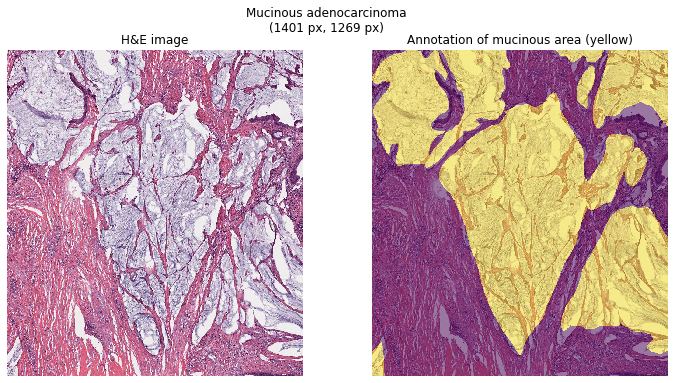

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128         

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

H&E is of type <class 'numpy.ndarray'>, has dimensions (1401, 1269, 3), and a total number of 5333607 elements


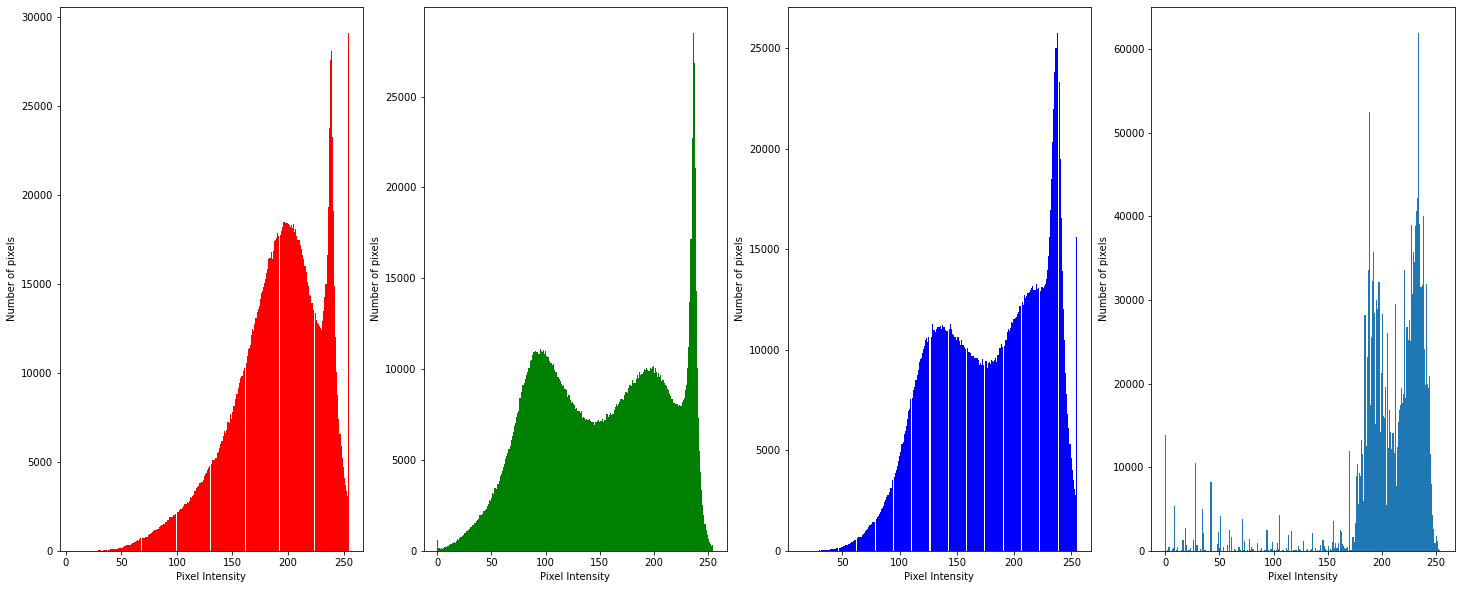

In [3]:
# to do
print('H&E is of type {}, has dimensions {}, and a total number of {} elements'.format(
    type(adeno_img), adeno_img.shape, adeno_img.size))

nb_bins = 256


# Separate the channels
r = adeno_img[:,:,0]
g = adeno_img[:,:,1]
b = adeno_img[:,:,2]

adeno_hsv = skimage.color.rgb2hsv(adeno_img)

h = adeno_hsv[:,:,0]*255

ch_list= [r,g,b,h]

# Set the number of bins
nb_bins = 256

# Plot the histograms
fig, ax = plt.subplots(1, 4, figsize=(25, 10))


ax[0].hist(r.ravel(), bins=nb_bins, color='red')
ax[1].hist(g.ravel(), bins=nb_bins, color='green')
ax[2].hist(b.ravel(), bins=nb_bins, color='blue')
ax[3].hist(h.ravel(), bins=nb_bins)

for i in range(0,4):
    ax[i].set_xlabel('Pixel Intensity')
    ax[i].set_ylabel('Number of pixels')

plt.show()


#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

Minimum errors of the R, G, B, Hue channels respectively: [0.44522065461516014, 0.26148214519742463, 0.2735150902569312, 0.18894305485949758]
The threshold values of the R, G, B, Hue channels respectively: [195, 145, 177, 213]


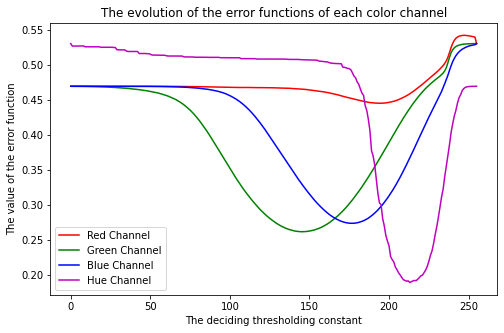

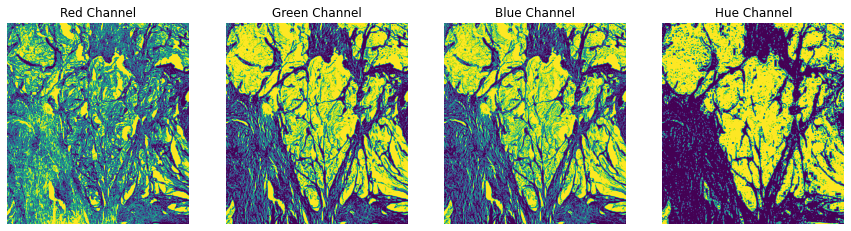

In [4]:
# to do
import skimage.filters

def error_func (width, height, image, target_image):
    
    equal=np.equal(image, target_image)
    sum=np.sum(equal)
            
    return 1- ((1/(width*height))*sum)


error_list=np.empty((256,4))
band=np.linspace(0,255,256)

min_errors= []
threshold_values= []
binary_images= []

fig_plot, ax_plot=plt.subplots(1,1, figsize=(8,5))
fig, ax=plt.subplots(1,len(ch_list), figsize=(15,6))

ax_titles = ["Red Channel", "Green Channel", "Blue Channel", "Hue Channel"]
colors = ['r', 'g', 'b', 'm']


for ch_num in range(0,len(ch_list)):

    channel=ch_list[ch_num]
    
    for tvalue in band:

        if ch_num==3:
            error_list[int(tvalue)][ch_num]=error_func(channel.shape[0], channel.shape[1], channel<tvalue, adeno_gt)
        else:
            error_list[int(tvalue)][ch_num]=error_func(channel.shape[0], channel.shape[1], channel>tvalue, adeno_gt)
        
    min_errors.append(np.min(error_list[:,ch_num]))
    threshold_values.append(np.argmin(error_list[:,ch_num], axis=0))

    if ch_num==3:
        binary_images.append(channel<threshold_values[ch_num])
    else:
        binary_images.append(channel>threshold_values[ch_num])

    ax[ch_num].imshow(binary_images[ch_num])
    ax[ch_num].set_title(ax_titles[ch_num])
    ax[ch_num].axis('off')
    ax_plot.plot(band, error_list[:, ch_num], label = ax_titles[ch_num], color=colors[ch_num])
    ax_plot.legend(loc='lower left')


ax_plot.set_title("The evolution of the error functions of each color channel")
ax_plot.set_xlabel("The deciding thresholding constant")
ax_plot.set_ylabel("The value of the error function")

    
print("Minimum errors of the R, G, B, Hue channels respectively: " + str(min_errors))
print("The threshold values of the R, G, B, Hue channels respectively: " + str(threshold_values))
plt.show()

#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [5]:
# TODO: replace variabel with your own threshod
mask_thesholding = binary_images[3]

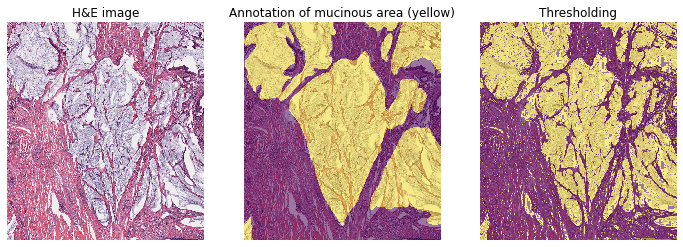

In [6]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(adeno_img, interpolation='nearest')
ax[2].imshow(mask_thesholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

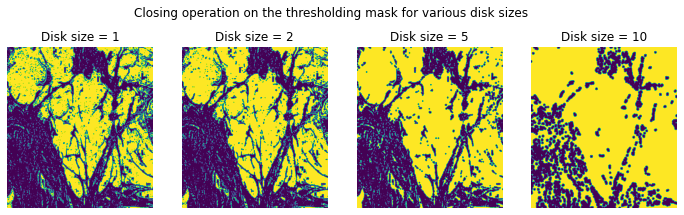

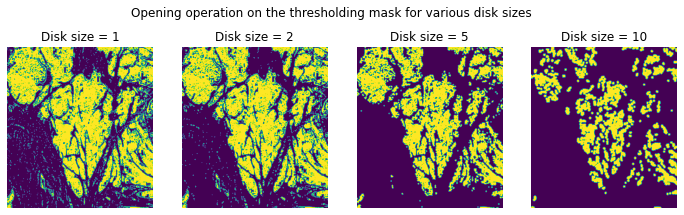

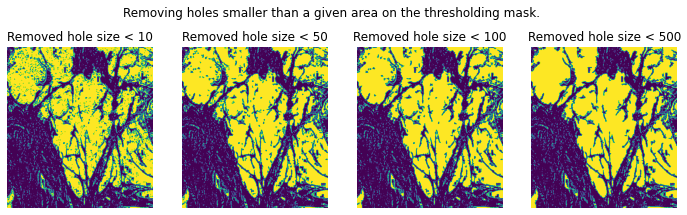

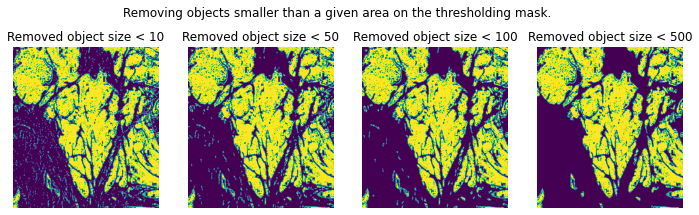

In [7]:
values1 = [1, 2, 5, 10]
fig_closing, ax_closing =plt.subplots(1,4, figsize=(12, 3.5))
fig_opening, ax_opening =plt.subplots(1,4, figsize=(12, 3.5))
fig_closing.suptitle("Closing operation on the thresholding mask for various disk sizes")
fig_opening.suptitle("Opening operation on the thresholding mask for various disk sizes")


for i in range(0, len(values1)):
    
    disk=skimage.morphology.disk(values1[i])
    closed=skimage.morphology.closing(mask_thesholding, disk)
    opened=skimage.morphology.opening(mask_thesholding, disk)
    
    ax_closing[i].imshow(closed)
    ax_closing[i].set_title(str("Disk size = ")+str(values1[i]))
    ax_closing[i].axis('off')

    ax_opening[i].imshow(opened)
    ax_opening[i].set_title(str("Disk size = ")+str(values1[i]))
    ax_opening[i].axis('off')

values2 = [10, 50, 100, 500]

fig_rm_holes, ax_rm_holes =plt.subplots(1,4, figsize=(12, 3.5))
fig_rm_objects, ax_rm_objects =plt.subplots(1,4, figsize=(12, 3.5))
fig_rm_holes.suptitle("Removing holes smaller than a given area on the thresholding mask.")
fig_rm_objects.suptitle("Removing objects smaller than a given area on the thresholding mask.")

for i in range(0, len(values2)):
    
    threshold_area= values2[i]
    rm_holes=skimage.morphology.remove_small_holes(mask_thesholding, threshold_area)
    rm_objects=skimage.morphology.remove_small_objects(mask_thesholding, threshold_area)
    
    ax_rm_holes[i].imshow(rm_holes)
    ax_rm_holes[i].set_title(str("Removed hole size < ")+str(values2[i]))
    ax_rm_holes[i].axis('off')

    ax_rm_objects[i].imshow(rm_objects)
    ax_rm_objects[i].set_title(str("Removed object size < ")+str(values2[i]))
    ax_rm_objects[i].axis('off')



The best error obtained by combining morphology techniques is: 0.09608244476955285


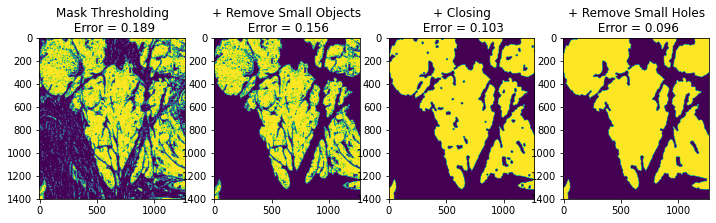

In [8]:
fig_c, ax_c = plt.subplots(1,4, figsize=(12,5))
ax_c[0].imshow(mask_thesholding)


rso=skimage.morphology.remove_small_objects(mask_thesholding, 5000) # keep this, it denoises
ax_c[1].imshow(rso)



disk_closing=skimage.morphology.disk(8)
closing=skimage.morphology.closing(rso, disk_closing)
ax_c[2].imshow(closing)

rsh=skimage.morphology.remove_small_holes(closing, 3000)
ax_c[3].imshow(rsh)
ax_c[0].set_title("Mask Thresholding\n Error = {:.3f}".format((error_func(mask_thesholding.shape[0], mask_thesholding.shape[1], mask_thesholding, adeno_gt))))
ax_c[1].set_title("+ Remove Small Objects\n Error = {:.3f}".format((error_func(mask_thesholding.shape[0], mask_thesholding.shape[1], rso, adeno_gt))))
ax_c[2].set_title("+ Closing\n Error = {:.3f}".format((error_func(mask_thesholding.shape[0], mask_thesholding.shape[1], closing, adeno_gt))))
ax_c[3].set_title("+ Remove Small Holes\n Error = {:.3f}".format((error_func(mask_thesholding.shape[0], mask_thesholding.shape[1], rsh, adeno_gt)))) 

print("The best error obtained by combining morphology techniques is: "+str(error_func(mask_thesholding.shape[0], mask_thesholding.shape[1], rsh, adeno_gt)))

mask_morph=rsh



---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

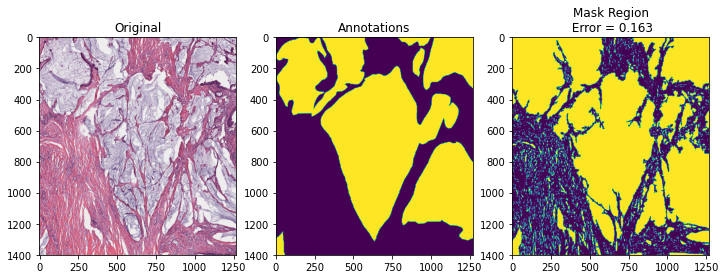

In [9]:
import cv2

#Extracting the hue channel
hsv_img = cv2.cvtColor(adeno_img, cv2.COLOR_BGR2HSV)
img = hsv_img[:, :, 0]



def region_grow(img, seed, thresh):
   
    #initialize empty binary mask with the same shape as the input image
    mask = np.zeros_like(img)
    seed_list = [seed] 
    
    
    # we chose 8 neighbors
    neighbors = [(-1,-1), (-1, 0), (-1, 1), (0, 1), (1,1), (1,0), (1,-1), (0,-1)]

    #loop through the seeds
    while seed_list:
        current_seed = seed_list.pop(0)

        for neighbor in neighbors:  #iterate through the neighbors 
            row = current_seed[0] + neighbor[0]
            col = current_seed[1] + neighbor[1]

            if row >= 0 and row < img.shape[0] and col >= 0 and col < img.shape[1]: #if the indices of the neighbours are within the bond
                if mask[row, col] == 0: #if it has not been visited yet
                    
                    #Absolute difference between the hue values of the neighbors and the current seed
                    if abs(int(img[row, col]) - int(img[current_seed])) <= thresh:   
                        
                        # Mark the neighbor as visited and add it to the mask and seed list
                        mask[row, col] = 255
                        seed_list.append((row, col))

    return mask

#seeds are first selected randomly, then selected based on the results we get
seeds = [(200,350),(600,200)] 
thresh = 1


masks = []

#apply the growing function to each seed
for seed in seeds:
    masks.append(region_grow(img, seed, thresh))

# Combine the masks
mask_region = np.zeros_like(img)
for mask in masks:
    mask_region = cv2.bitwise_or(mask_region, mask)


# convert to an array
mask_region = np.array(mask_region)

#inverse the black and white because we selected the pixels that are less than the thresh value
#if we select the pixels that are greater than the thresh value, the error would be bigger
mask_region = np.where(mask_region == 0, 255, 0)
mask_region = mask_region/255 #get a binary array to calculate the error


# Show the results

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].imshow(adeno_img)
axs[0].set_title('Original')
axs[1].imshow(adeno_gt)
axs[1].set_title('Annotations')
axs[2].imshow(mask_region)
axs[2].set_title('Mask Region\n Error = {:.3f}'.format((error_func(mask_region.shape[0], mask_region.shape[1], mask_region, adeno_gt))))
plt.show()


---
### 1.5 Method comaprison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

#### Comments
In the three techniques used, we have noticed an error rate that varies between 9 to 19%. Looking at the images, the `mask_thresholding` approach is less blurry than the others but is more noisy. After applying the `mask_morph` (remove_small_objects, then closing, then remove_small_holes) on the `mask_thresholding`, the noise is completely removed, thus, the error rate is minimized by almost 10%. The residual error is due to some holes that are hard to remove because they lack connectivity. The `mask_region` approach showed more efficiency than the thresholding one, as a good amount of noises on the mucinous area is removed but there are also some important parts that are not removed. The issue of our `mask_region` is that, the way to select the seeds are first to select a point in any area outside of the mucinous area, then the algorithm will perform the region growing. However some areas might not be connected to each other. Therefore, we need to select at least one seed for each area. The region growing algorithm might not be efficient on other images if we select the same seeds. Additionally, note that we have performed the algorithm on the background of the image, if we perform it on the foreground, the error will be higher and we will also have to include more seeds. Although that this method reduces the error, it does not remove some important areas. To conclude, although the error rates are low, we can do more. A good approach would be combining the region growing algorithm with morphology techniques.

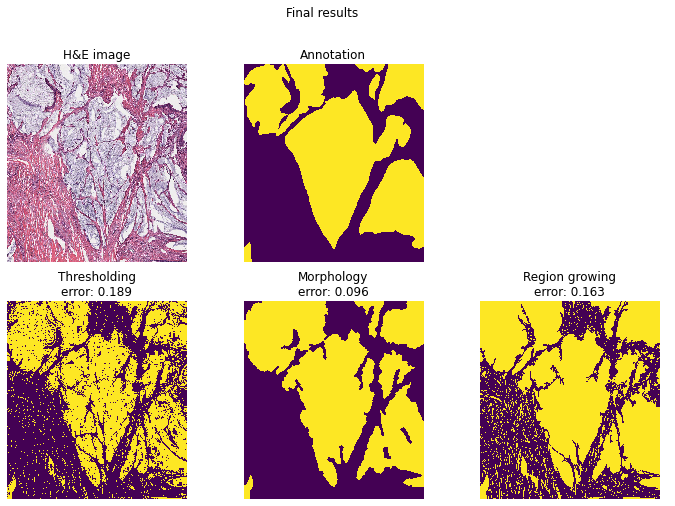

In [10]:
error_th = 1- (mask_thesholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thesholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 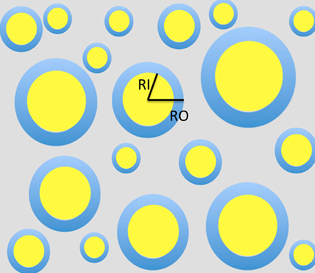

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 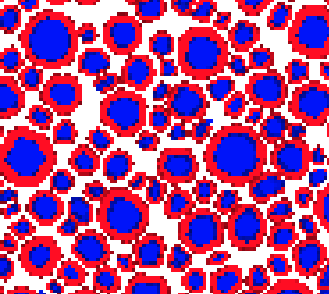

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learinng" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

In [11]:
data_base_path

'..\\data'

..\data


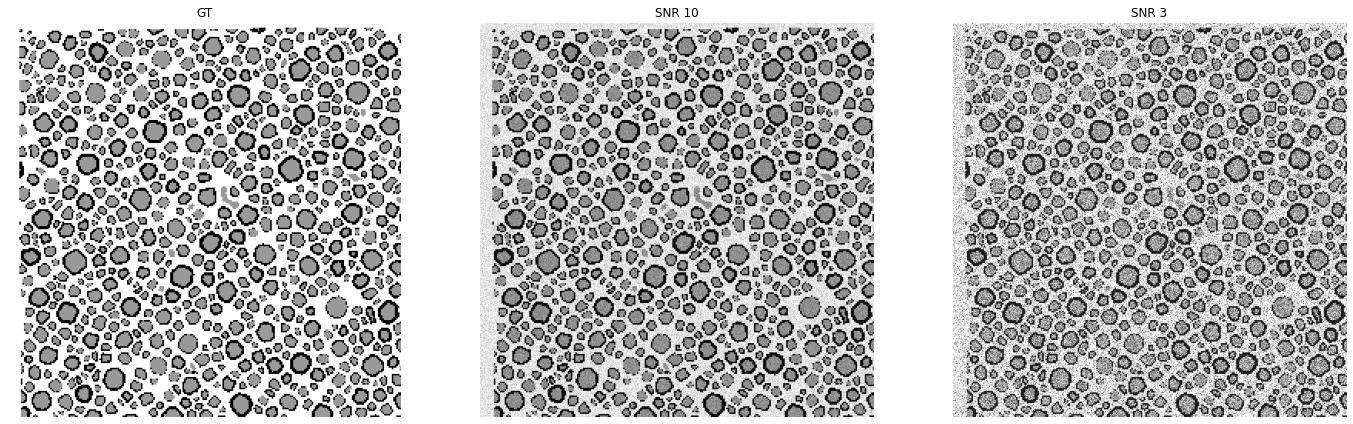

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0], cv2.IMREAD_GRAYSCALE)
snr_10 = cv2.imread(path_folder+ files[1], cv2.IMREAD_GRAYSCALE)
snr_3 = cv2.imread(path_folder+ files[2], cv2.IMREAD_GRAYSCALE)


images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()


### 2.1.1 Preprocessing 
 % add your images about preprocessing


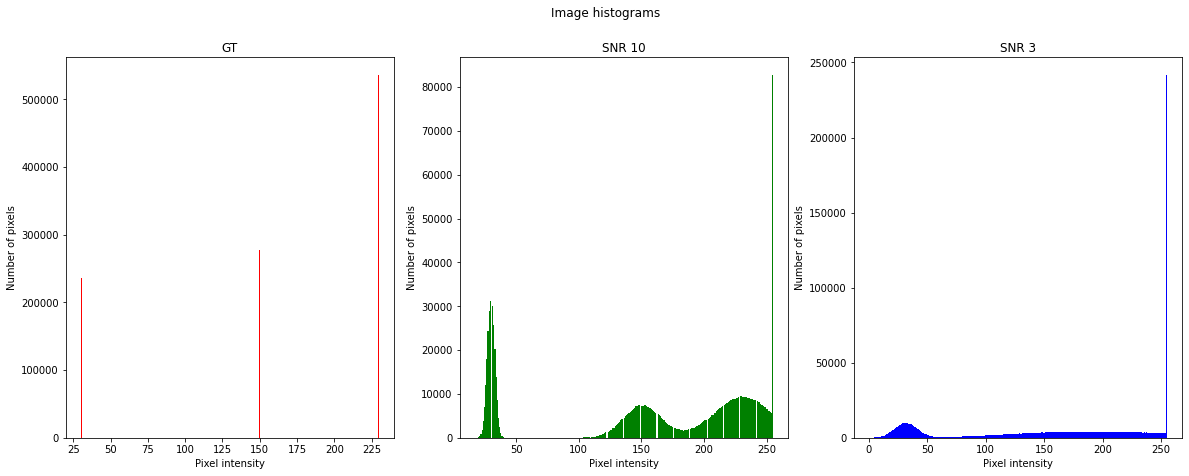

In [13]:
# Plot the histograms
nb_bins = 256

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].hist(gt_0.ravel(), bins=nb_bins, color='red')
ax[0].set_title('GT')
ax[0].set_xlabel('Pixel intensity')
ax[0].set_ylabel('Number of pixels')

ax[1].hist(snr_10.ravel(), bins=nb_bins, color='green')
ax[1].set_title('SNR 10')
ax[1].set_xlabel('Pixel intensity')
ax[1].set_ylabel('Number of pixels')

ax[2].hist(snr_3.ravel(), bins=nb_bins, color='blue')
ax[2].set_title('SNR 3')
ax[2].set_xlabel('Pixel intensity')
ax[2].set_ylabel('Number of pixels')

plt.suptitle('Image histograms')
plt.show()

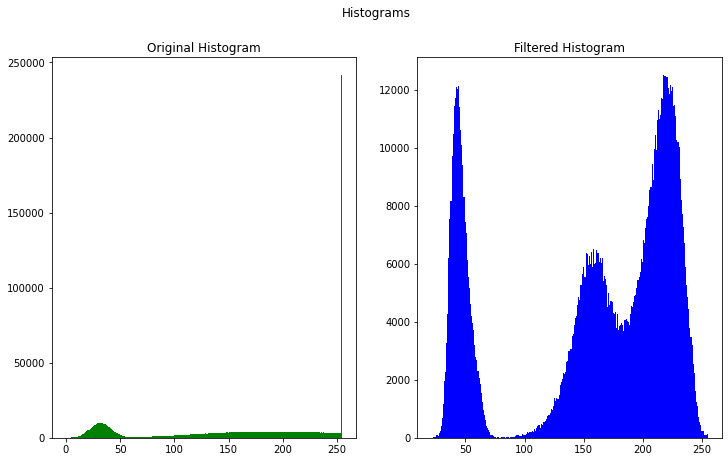

True

In [14]:
# Denoising snr_3
from skimage import io, restoration
from skimage.filters import median

snr_3_filt = restoration.denoise_wavelet(snr_3, sigma=60)*255

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].hist(snr_3.ravel(), bins=nb_bins, color='green')
ax[0].set_title('Original Histogram')
ax[1].hist(snr_3_filt.ravel(), bins=nb_bins, color='blue')
ax[1].set_title('Filtered Histogram')

plt.suptitle('Histograms')
plt.show()

cv2.imwrite('snr.png', snr_3_filt)

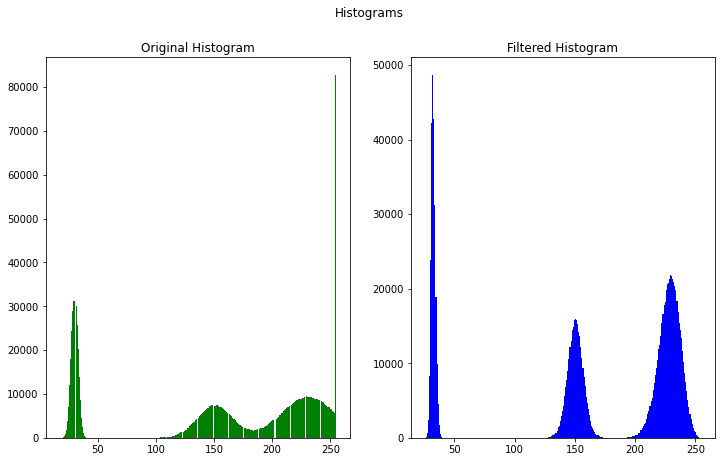

In [15]:
# Denoising snr_10
from skimage import io, restoration

snr_10_filt = restoration.denoise_wavelet(snr_10, sigma=25)*255

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].hist(snr_10.ravel(), bins=nb_bins, color='green')
ax[0].set_title('Original Histogram')
ax[1].hist(snr_10_filt.ravel(), bins=nb_bins, color='blue')
ax[1].set_title('Filtered Histogram')

plt.suptitle('Histograms')
plt.show()



### 2.1.2 Results Segmetations( 3 points GT  , 1 point Test case 1, 1 point test case 2)

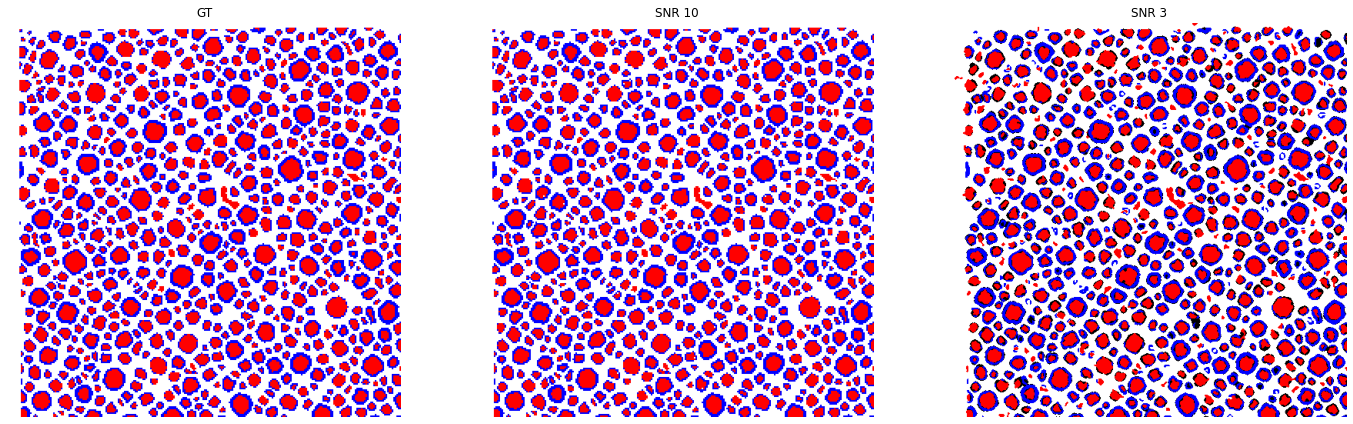

In [16]:
# Segmenting the images
import cv2
from skimage.morphology import remove_small_objects, remove_small_holes, closing, opening, disk, binary_closing
from skimage.filters import median

disk = disk(4)


#segmenting GT 0 image
gt_0_back = gt_0 > 200
gt_0_out = gt_0 < 100
gt_0_in = (gt_0>100) & (gt_0 <200)

#segmenting SNR 10 image
snr_10_back = snr_10_filt > 170
snr_10_out = snr_10_filt < 100
snr_10_in = remove_small_holes((snr_10_filt>100) & (snr_10_filt <170), area_threshold = 100)

#segmenting SNR 3 image
snr_3_back = closing(remove_small_objects(remove_small_holes(median(snr_3 > 200), area_threshold=100), min_size=10),disk)
snr_3_out = remove_small_objects(median(snr_3 < 80), min_size=9)
snr_3_in = binary_closing(median(binary_closing(remove_small_holes(remove_small_objects(median((snr_3>80) & (snr_3 <200)), min_size=15), area_threshold=200))))


#Display the segmented images in the prescribed color code
def create_RGB_image(image1, image2, image3, color1, color2, color3):
    # Make 3 channel RGB image same dimensions
    RGB = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Make True pixels red
    RGB[image1] = color1
    
    # Make True pixels white
    RGB[image2] = color2
    
    # Make True pixels blue
    RGB[image3] = color3
    
    return RGB

inner = [255, 0, 0]  # red
outer= [0, 0, 255]  # blue
back = [255, 255, 255]  # white

GT0=create_RGB_image(gt_0_back, gt_0_out, gt_0_in, back, outer, inner)
SNR10=create_RGB_image(snr_10_back, snr_10_out, snr_10_in, back, outer, inner)
SNR3=create_RGB_image(snr_3_back, snr_3_out, snr_3_in, back, outer, inner)

images=[GT0, SNR10, SNR3]
#images = [GT0,SNR10, SNR3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()


### 2.1.3 Radii histrograms (2 point)

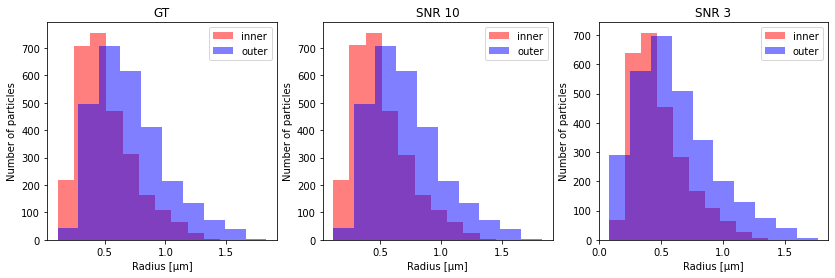

In [17]:
## results Radii distribution. proposal feel free to change it
import numpy as np
from skimage import measure

def get_radii(image):

    # Label the connected components in the image
    labels = measure.label(image)
    # Count the number of objects in the image
    #print(np.max(labels))
    # Calculate the area and radius of each object
    areas = np.bincount(labels.ravel())[1:]
    radii = np.sqrt(areas / np.pi)*0.1
    
    return  radii #, num_objects, areas,


rads_inner_gt = get_radii(gt_0_in)
rads_outer_gt = get_radii(gt_0_out+gt_0_in)

rads_inner_snr10 = get_radii(snr_10_in)
rads_outer_snr10 = get_radii(snr_10_out+snr_10_in)

rads_inner_snr3 = get_radii(snr_3_in)
rads_outer_snr3 = get_radii(snr_3_out+snr_3_in)


rads_gt = [ rads_inner_gt ,rads_outer_gt]
rads_snr10 = [ rads_inner_snr10 ,rads_outer_snr10]  # your result
rads_snr3 = [ rads_inner_snr3,rads_outer_snr3]  # your result

all_rads= [rads_gt , rads_snr10 , rads_snr3] 


im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
    ax.set_xlabel('Radius [µm]')
    ax.set_ylabel('Number of particles')
plt.show()


### 2.4 Low frequencies

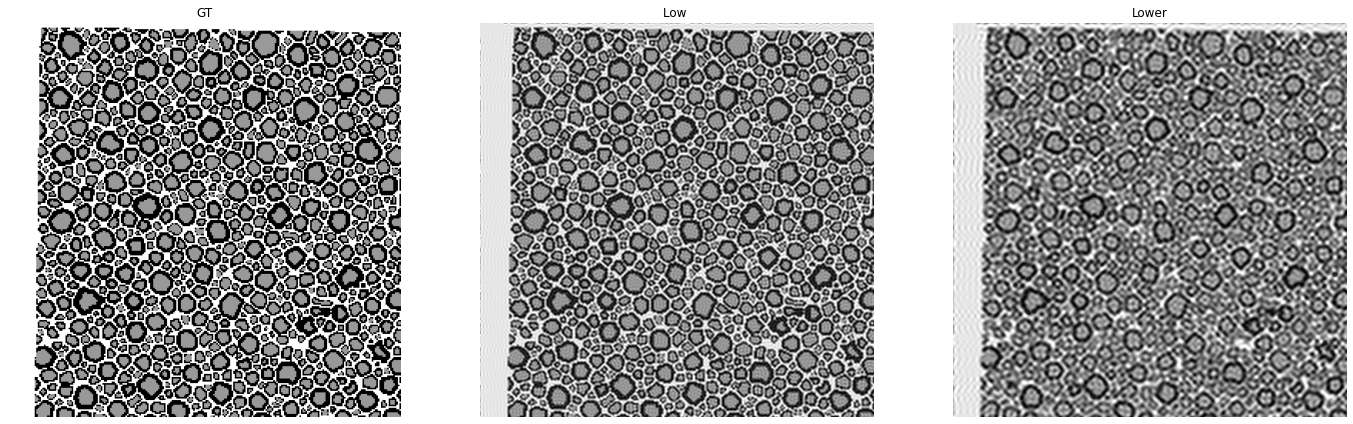

In [18]:

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0], cv2.IMREAD_GRAYSCALE)
lowfreq0 = cv2.imread(path_folder+ files[1], cv2.IMREAD_GRAYSCALE)
lowfreq1 = cv2.imread(path_folder+ files[2], cv2.IMREAD_GRAYSCALE)

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.4.1 Preprocessing



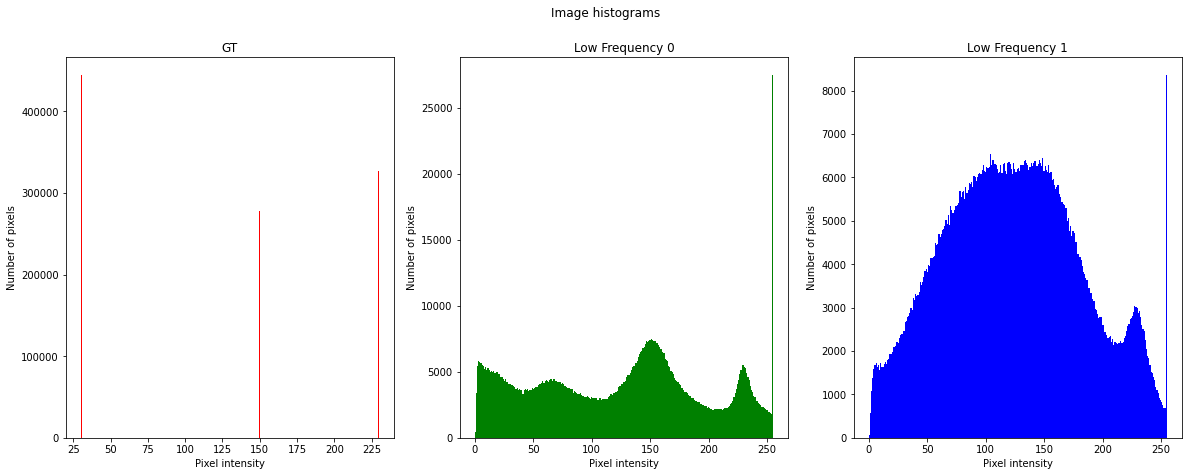

In [19]:
# Plot the histograms
nb_bins = 256

fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].hist(gt_3.ravel(), bins=nb_bins, color='red')
ax[0].set_title('GT')
ax[0].set_xlabel('Pixel intensity')
ax[0].set_ylabel('Number of pixels')

ax[1].hist(lowfreq0.ravel(), bins=nb_bins, color='green')
ax[1].set_title('Low Frequency 0')
ax[1].set_xlabel('Pixel intensity')
ax[1].set_ylabel('Number of pixels')

ax[2].hist(lowfreq1.ravel(), bins=nb_bins, color='blue')
ax[2].set_title('Low Frequency 1')
ax[2].set_xlabel('Pixel intensity')
ax[2].set_ylabel('Number of pixels')

plt.suptitle('Image histograms')
plt.show()

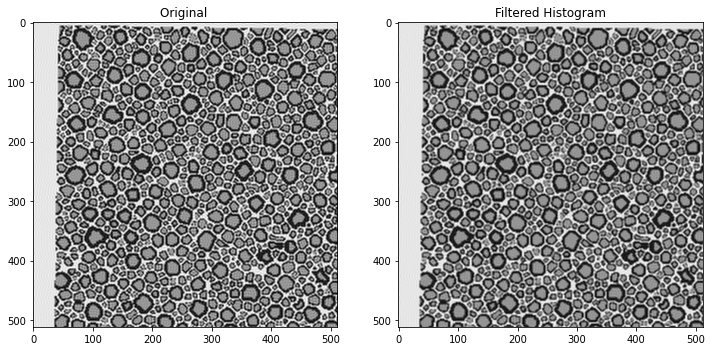

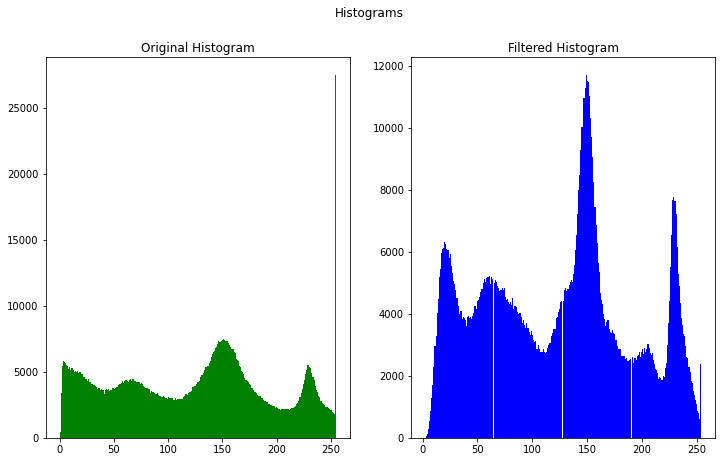

True

In [20]:
# Denoising snr_10
import cv2

lowfreq0_filt =cv2.medianBlur(lowfreq0, 3)*255
lowfreq0_filt=cv2.bitwise_not(lowfreq0_filt)


fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].imshow(lowfreq0[0:512, 0:512], cmap='gray')
ax[0].set_title('Original ')
ax[1].imshow(lowfreq0_filt[0:512, 0:512], cmap='gray')
ax[1].set_title('Filtered Histogram')

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].hist(lowfreq0.ravel(), bins=nb_bins, color='green')
ax[0].set_title('Original Histogram')

ax[1].hist(lowfreq0_filt.ravel(), bins=nb_bins, color='blue')
ax[1].set_title('Filtered Histogram')

plt.suptitle('Histograms')
plt.show()

cv2.imwrite('test.png', lowfreq0_filt)



### 2.4.2 Results Segmetations


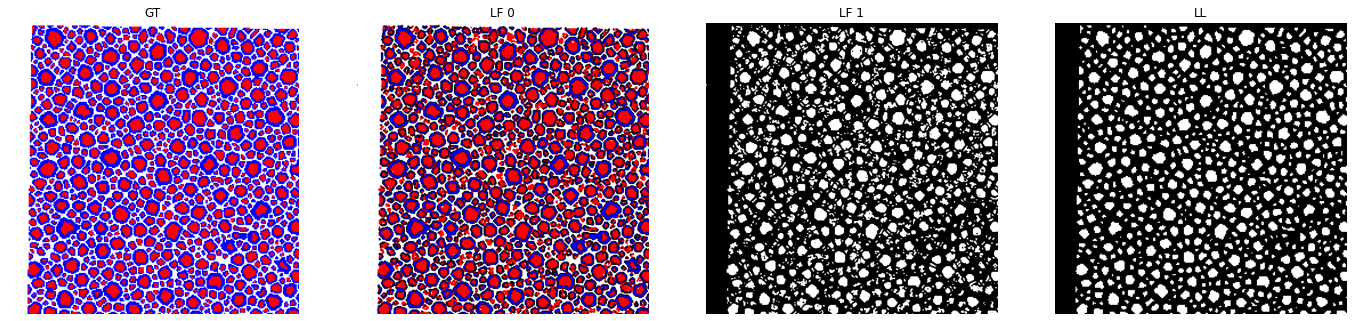

In [21]:
from skimage.morphology import remove_small_objects, remove_small_holes, closing, binary_opening, disk, binary_erosion, opening
from skimage.filters import median

disk = disk(2)

#segmenting GT 3 image
gt_3_back = gt_3 > 200
gt_3_out = gt_3 < 50
gt_3_in = (gt_3>100) & (gt_3 <200)

#segmenting lowfreq 0 image
lowfreq0_back = median(lowfreq0_filt > 160)
lowfreq0_out = binary_erosion(median(lowfreq0_filt < 90))
lowfreq0_in = median((lowfreq0_filt < 160) & (lowfreq0_filt > 90))

#segmenting lowfreq 0 image
lowfreq1_back = median(lowfreq1 > 200)
lowfreq1_out = median(lowfreq1 < 50)
lowfreq1_in = median((lowfreq1>100) & (lowfreq1 <200))


GT3=create_RGB_image(gt_3_back, gt_3_out, gt_3_in, back, outer, inner)
LF0=create_RGB_image(lowfreq0_back, lowfreq0_out, lowfreq0_in, back, outer, inner)
LF1=create_RGB_image(lowfreq1_back, lowfreq1_out, lowfreq1_in, back, outer, inner)

images = [GT3, LF0, lowfreq0_in, gt_3_in ]
im_names = ["GT" , "LF 0" , "LF 1", "LL"]
fig, axes = plt.subplots(1, 4, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()



### 2.4.3 Radii histrograms

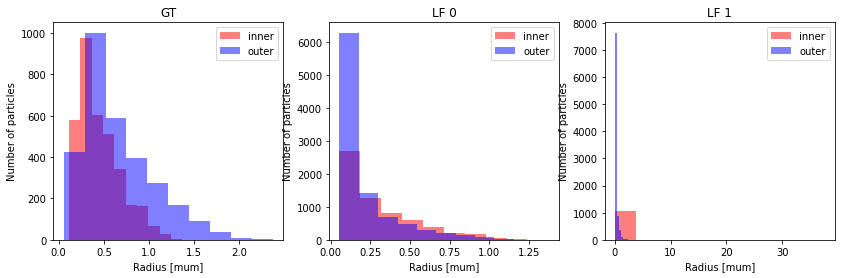

In [22]:
rads_inner_gt3 = get_radii(gt_3_in)
outer_gt_3 = binary_erosion(gt_3_in+gt_3_out)
rads_outer_gt3 = get_radii(outer_gt_3)

rads_inner_lf0 = get_radii(lowfreq0_in)
outer_lf0 = binary_erosion(lowfreq0_in+lowfreq0_out)
rads_outer_lf0 = get_radii(outer_lf0)

rads_inner_lf1 = get_radii(lowfreq1_in)
outer_lf1 = binary_erosion(lowfreq1_in+lowfreq1_out)
rads_outer_lf1 = get_radii(outer_lf1)

rads_gt3 = [ rads_inner_gt3 ,rads_outer_gt3]
rads_lf0 = [ rads_inner_lf0 ,rads_outer_lf0]
rads_lf1 = [ rads_inner_lf1 ,rads_outer_lf1]

all_rads= [rads_gt3, rads_lf0, rads_lf1] 
im_names = ["GT" , "LF 0" , "LF 1"]
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
    ax.set_xlabel('Radius [mum]')
    ax.set_ylabel('Number of particles')
plt.show()

### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

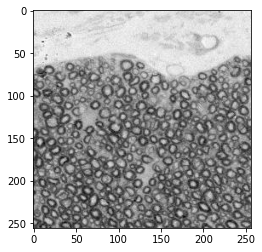

In [23]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png" ]
real_data = cv2.imread(path_folder+ files[0], cv2.IMREAD_GRAYSCALE)

plt.imshow(real_data[:256, :256], cmap='gray')



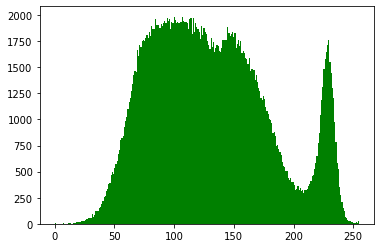

In [24]:

plt.hist(real_data.ravel(), bins=nb_bins, color='green')
plt.show()

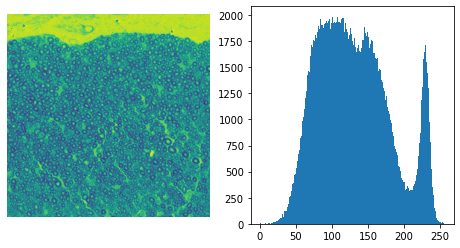

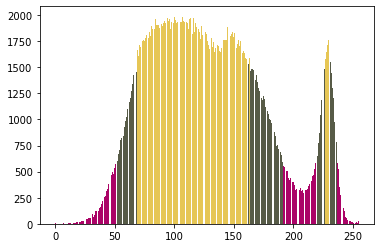

In [25]:
import matplotlib.pyplot as plt
from skimage import io
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap

# Load the image
image = real_data

# Plot the image and its histogram
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[0].axis('off')
n, bins, patches = axes[1].hist(image.ravel(), bins=256, range=[0, 256])
plt.show()

# Reshape the histogram into an array
X = np.array([n]).T

# Cluster the histogram using Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=3, random_state=0).fit(X)

# Assign the labels to the histogram bins
labels = gmm.predict(X)

# Define a colormap with 20 distinct colors
cmap = ListedColormap(np.random.rand(20, 3))

# Map the cluster labels to color values using the colormap
colors = cmap(labels)

# Plot the clustered histogram with color-coded bins
plt.bar(range(256), n, color=colors)
plt.show()



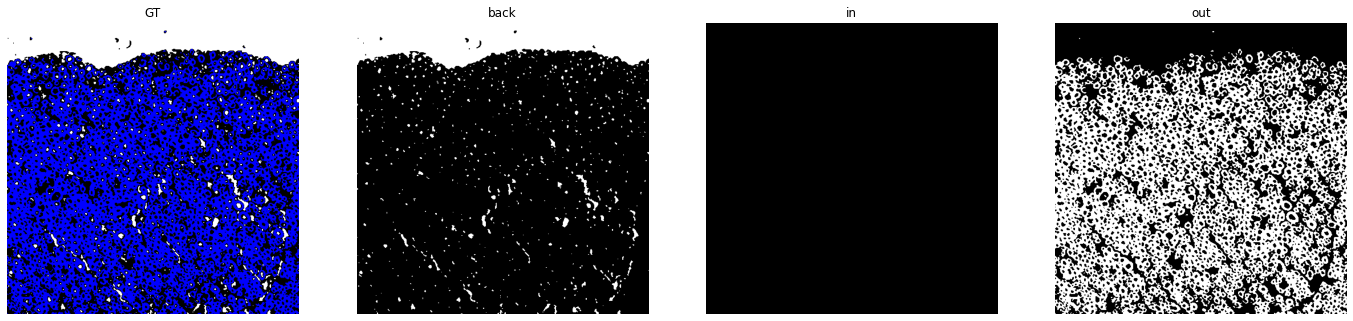

In [26]:
from skimage.morphology import remove_small_objects, remove_small_holes, closing, binary_opening, disk, binary_erosion, opening
from skimage.filters import median

disk = disk(5)

#segmenting GT 3 image
rd_back = median(real_data > 180)
rd_out = median(real_data < 125)
rd_in = opening((real_data>125) & (real_data <180), disk)

RD=create_RGB_image(rd_back, rd_out, rd_in, back, outer, inner)


images = [RD, rd_back, rd_in, rd_out]
im_names = ["GT" , "back" , "in", "out"]
fig, axes = plt.subplots(1, 4, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()
